## Image Segmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 1

Autosaving every 1 seconds


#### Before running this notebook, manipulate data using Data.ipynb (see README.md)

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import zipfile
import cv2

In [3]:
path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/vocal_cords_and_rings_data/data/images/472d6b31-0000000.png'),
 PosixPath('/storage/vocal_cords_and_rings_data/data/images/6af7eb79-0000000.png'),
 PosixPath('/storage/vocal_cords_and_rings_data/data/images/eed4e11f-0000000.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage/vocal_cords_and_rings_data/data/labels/472d6b31-0000000.png'),
 PosixPath('/storage/vocal_cords_and_rings_data/data/labels/6af7eb79-0000000.png'),
 PosixPath('/storage/vocal_cords_and_rings_data/data/labels/eed4e11f-0000000.png')]

# Define Codes and get_y_fn

`get_y_fn` returns the mask associated with a particular image

In [6]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [7]:
codes = np.loadtxt(path_lbl/'../../codes.txt', dtype=str); codes

array(['everything_else', 'vocal_cord', 'trachea_ring', 'bifurcation'], dtype='<U15')

# Look at data

PosixPath('/storage/vocal_cords_and_rings_data/data/images/9893aa71-0000000.png')

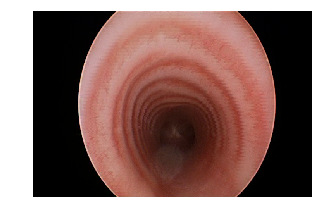

In [8]:
img_f = fnames[60]
img = open_image(img_f)
img.show(figsize=(5,5))
img_f

Make function that returns the label corresponding to a given image (i.e. the ground truth)

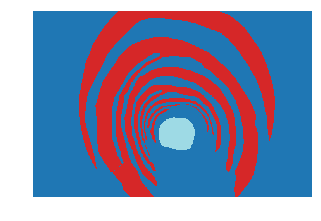

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

# Get rid of later

In [84]:
mask_cp = cv2.imread(str(get_y_fn(img_f)), cv2.IMREAD_GRAYSCALE)
mask_cp = (mask_cp==1).astype(np.uint8)
# plt.imshow(mask_cp==1)
# print(np.unique(mask_cp))
# mask_cp = cv2.cvtColor(mask_cp, cv2.COLOR_GRAY2BGR)
# print(mask_cp.shape)
# kernel = np.ones((3,3))
# # kernel = np
mask_d = cv2.dilate(mask_cp, np.ones((5,5)), iterations=12)
mask_overlap = mask_d-mask_cp

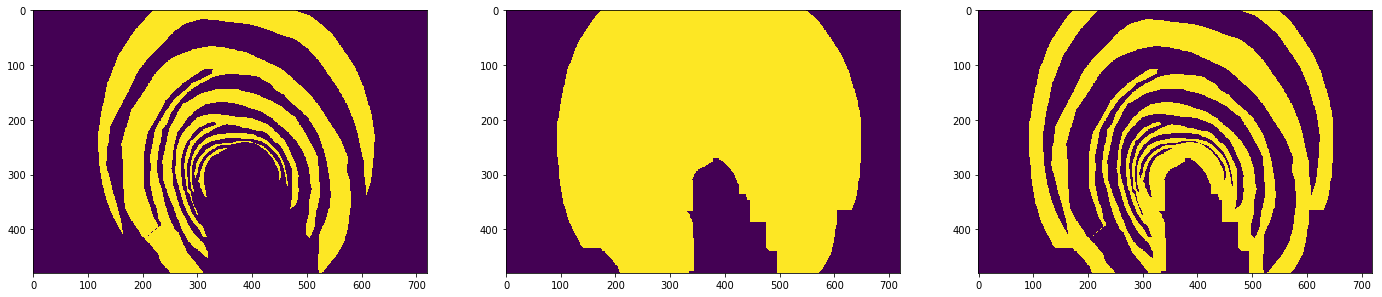

In [86]:
fig=plt.figure(figsize=(24,24))
columns = 3
rows = 1

# for c in range (71,100):
mask_list = [mask_cp, mask_d, mask_overlap]
for i in range(1, columns*rows +1):
    img = mask_list[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
#     clear_output()
plt.show()

# ENDOF get rid of later


In [10]:
src_size = np.array(mask.shape[1:])
np_mask = np.array(mask.data)
src_size, mask.data

(array([480, 720]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
np.unique(np_mask)

array([0, 1, 3])

## Datasets

In [12]:
# size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16268MB of GPU RAM free


In [13]:
bs=4

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(flip_vert=True, max_warp=0.3,max_rotate=45, max_lighting=0.3),size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

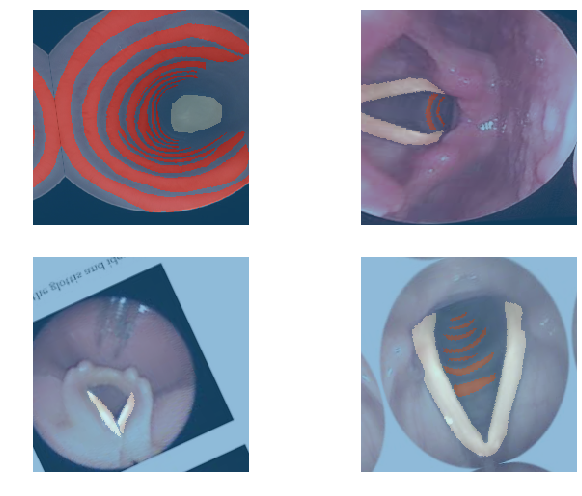

In [16]:
data.show_batch(2, figsize=(10,7))

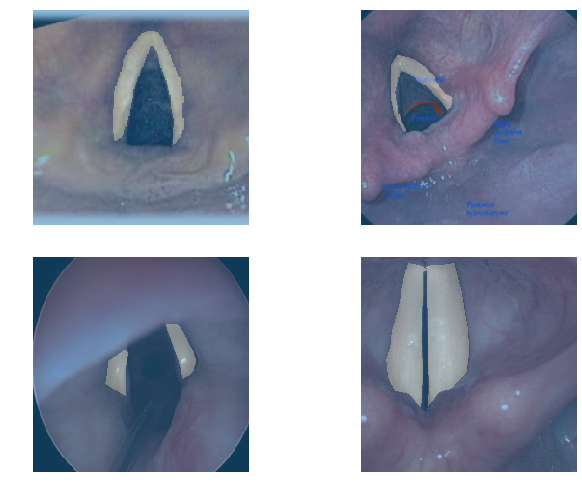

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

Make a custom accuracy metric

In [18]:
def acc_trachea(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

#     return (x.argmax(dim=1)==target and x[1][x.argmax(dim=1)]==1).float().mean()*weight[1] + (x.argmax(dim=1)==target and x[1][x.argmax(dim=1)]==2).float().mean()*weight[2]

In [21]:
f_score = partial(fbeta, thresh=0.2)
metrics=acc_trachea

In [20]:
wd=1e-2

#### Define multiple loss functions

In [20]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0].float()
    ret = torch.tensor(2. * torch.sum(m1*m2) / torch.sum(m1+m2), requires_grad=True)
    return ret

def focal_loss(pred, target, gamma=0):
    pred /= torch.sum(pred, dim=-1, keepdim=True)
    eps = 1e-07
    pred = torch.clamp(pred, eps, 1. - eps)
    return -torch.sum(torch.pow(1. - pred, gamma) * target * torch.log(pred))/(target.shape[1]*target.shape[2])

def cross_entropy_flat(pred, target):
    return CrossEntropyFlat(pred, target, weight=torch.tensor[1,1,1])

def multi_acc(logits, targets):
    bs, c, h, w = logits.size()
    out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
    input_ = out2.view(bs*h*w,c)

    # target for cross entropy
    _, idx = torch.max(targets, 1)
    target = idx.view(-1)

    return sum(torch.max(input_, dim=0)[1] == target) / len(target)

#### Assign one of the above loss functions to the loss class

In [21]:
from torch import nn
import torch.nn.functional as F
import numpy as np

class MulticlassBCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self):
        super(MulticlassBCELoss2d, self).__init__()
        
    def forward(self, logits, targets):
        # input for cross entropy
        bs, c, h, w = logits.size()
        out2 = logits.view(bs,c,h*w).transpose(2,1).contiguous()
        input_ = out2.view(bs*h*w,c)
        
        # target for cross entropy
        _, idx = torch.max(targets, 1)
        target = idx.view(-1)
        #return F.cross_entropy(input_, target, weight=torch.tensor([1,100,100]).float())
        return focal_loss(input_, target)

#### Make learner object with the corresponding loss function

In [22]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

#Commented to use the default params:

# learn.metrics=[acc_trachea]
# learn.crit=cross_entropy_flat
# learn.opt_fn=optim.Adam

#### Find the appropriate learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


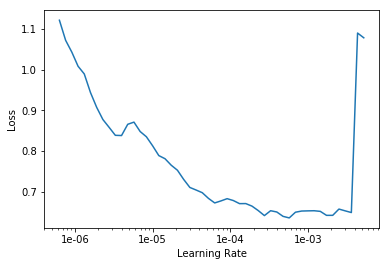

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=1e-4

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.489648,0.265152,0.936649,00:47
1,0.394413,0.270178,0.937091,00:43
2,0.369492,0.196496,0.938705,00:43
3,0.346427,0.207838,0.937084,00:43
4,0.317257,0.172525,0.947102,00:43
5,0.331276,0.157729,0.957467,00:43
6,0.299733,0.136254,0.956768,00:43
7,0.282856,0.178670,0.945898,00:43
8,0.288146,0.132761,0.955491,00:43
9,0.305630,0.174406,0.940287,00:43


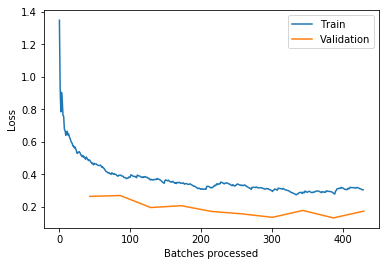

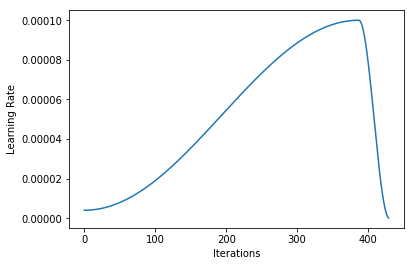

In [27]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

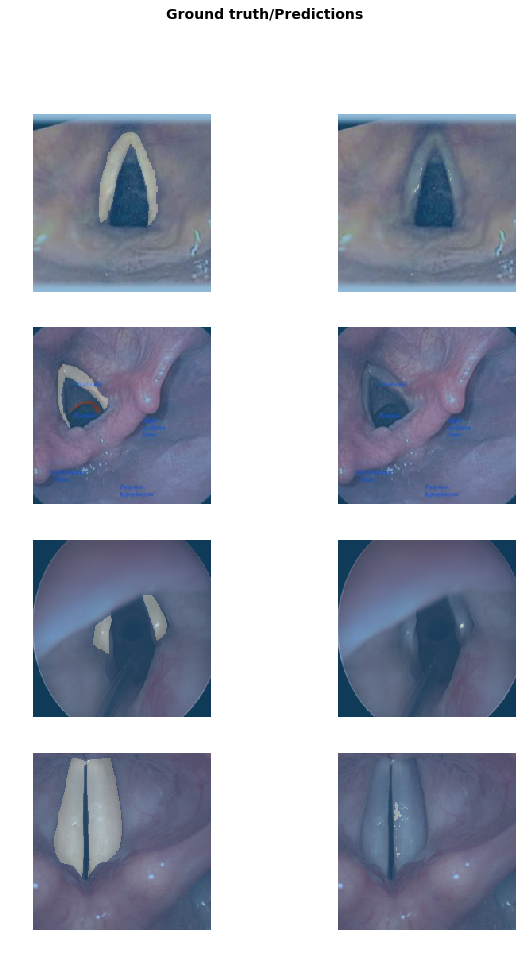

In [87]:
learn.show_results(rows=5, figsize=(10,15))

Looks like it could be improved. Let's keep training

In [88]:
learn.save('stage-1-07-09-rn50') #Save the trained model

#### Let's unfreeze all layers in the model

Unfreezing all layers will let the model learn more primitive shapes, gradients and patters. Before unfreezing, we were just training the final few layers in the UNet model. Training the last few layers first it an effective method to take advantage of transfer learning--taking a pre-trained model, appending a few layers at the end, and training those.

Unfreezing will allow us to build on top of the first stage of the trained model, and let us better learn features from the dataset. The variable learning rate will let us train the higher level features in the later layers more rapidly, while only slightly modifying the earlier layers. Generally speaking, the earlier layers learn to recognize more general features, so there is no need to train these layers with a high learning rate.

In [33]:
learn.load('stage-1-0709-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (173 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /storage/vocal_cords_and_rings_data/data/images;

Valid: LabelList (31 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /storage/vocal_cords_and_rings_data/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [89]:
learn.unfreeze()

In [90]:
lrs = slice(lr/400,lr/4)

In [91]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.243443,0.155690,0.944724,00:44
1,0.228878,0.142354,0.953775,00:44
2,0.222201,0.127816,0.961623,00:44
3,0.200148,0.129857,0.953482,00:44
4,0.184853,0.117133,0.961484,00:44
5,0.179408,0.138549,0.951445,00:44
6,0.169285,0.111470,0.962084,00:44
7,0.167278,0.108526,0.967285,00:44
8,0.172573,0.104132,0.966475,00:44
9,0.174210,0.157049,0.940776,00:44


In [92]:
learn.save('stage-2-0709-rn50', return_path=True)

PosixPath('/storage/vocal_cords_and_rings_data/data/images/models/stage-2-0709-rn50.pth')

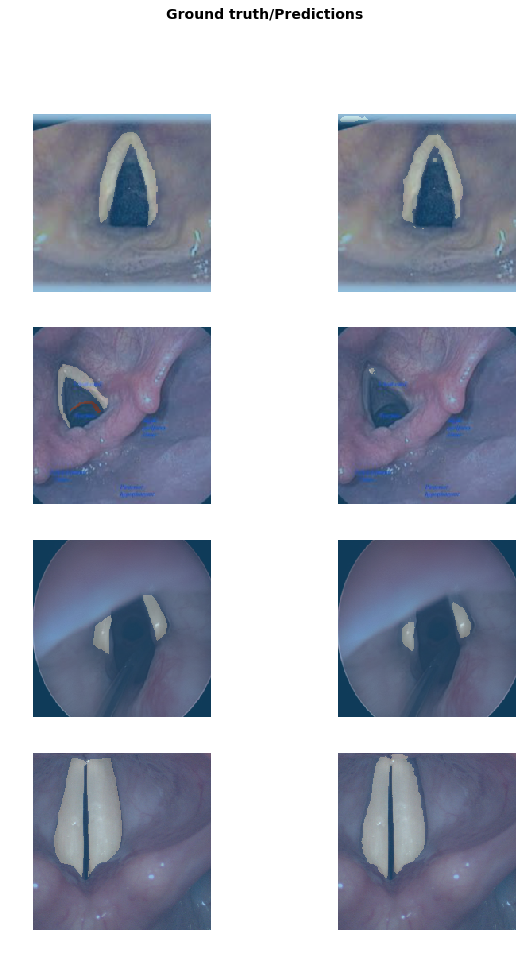

In [93]:
learn.show_results(rows=5, figsize=(10,15))

## Go big

In [94]:
#
learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=2, have 15745MB of GPU RAM free


In [95]:
data = (src.transform(get_transforms(flip_vert=True, max_warp=0.3,max_rotate=45, max_lighting=0.3), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [96]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

In [97]:
learn.load('stage-2-0709-rn50');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


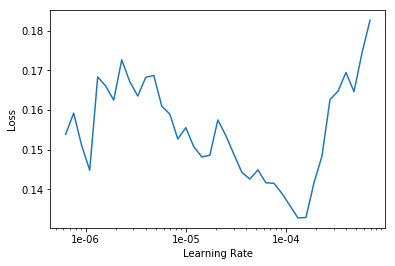

In [98]:
lr_find(learn)
learn.recorder.plot()

In [99]:
lr=1e-5

In [100]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.167105,0.110476,0.961885,00:54
1,0.154774,0.102376,0.963596,00:52
2,0.162121,0.165659,0.938691,00:52
3,0.155893,0.112443,0.959171,00:52
4,0.157237,0.098704,0.965432,00:52
5,0.144342,0.089650,0.969694,00:52
6,0.146968,0.092024,0.967878,00:52
7,0.155456,0.095627,0.966141,00:52
8,0.133661,0.100029,0.963183,00:52
9,0.144832,0.092914,0.966433,00:52


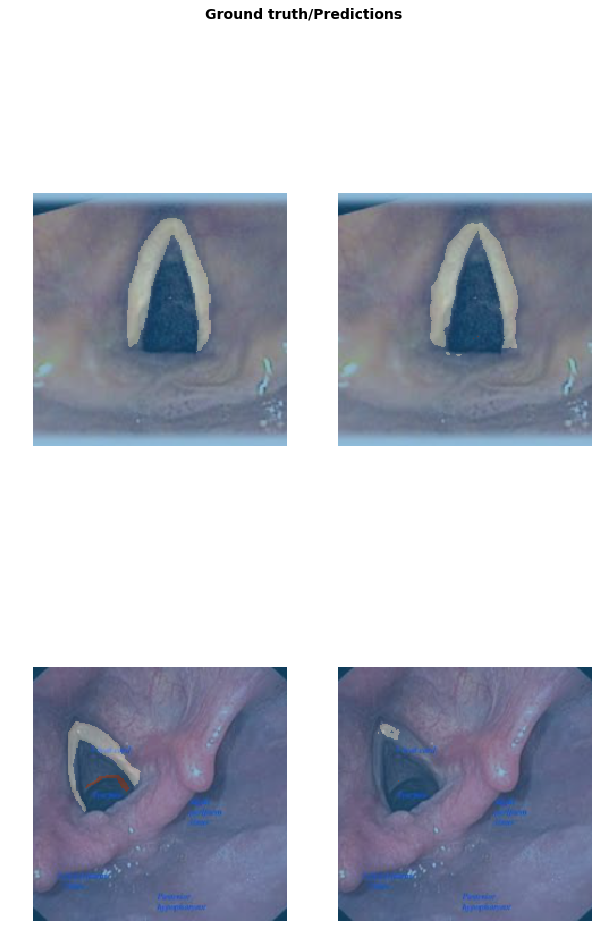

In [101]:
learn.show_results(rows=5, figsize=(10,16))

In [102]:
learn.save('stage-1-big-0709-rn50')

In [139]:
learn.load('stage-1-big-0709-rn50');

In [103]:
learn.unfreeze()

In [104]:
lrs = slice(1e-6,lr/10)

In [105]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_trachea,time
0,0.118472,0.101704,0.961336,00:54
1,0.121238,0.089351,0.969602,00:53
2,0.116870,0.093121,0.965395,00:53
3,0.113753,0.082280,0.970802,00:53
4,0.118102,0.091374,0.966402,00:53
5,0.114033,0.104916,0.962597,00:53
6,0.124462,0.085739,0.970321,00:53
7,0.121397,0.096963,0.964201,00:53
8,0.131027,0.085461,0.970613,00:53
9,0.144965,0.093561,0.965775,00:53


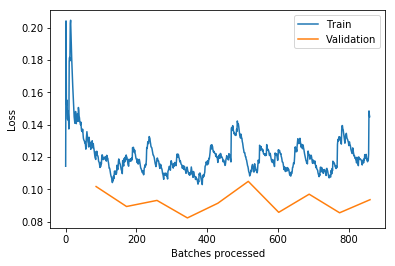

In [106]:
learn.recorder.plot_losses()

In [107]:
learn.save('stage-2-big-0709-rn50', return_path=True)

PosixPath('/storage/vocal_cords_and_rings_data/data/images/models/stage-2-big-0709-rn50.pth')

In [26]:
learn.load('stage-2-big-0709-rn50');

## Final Results

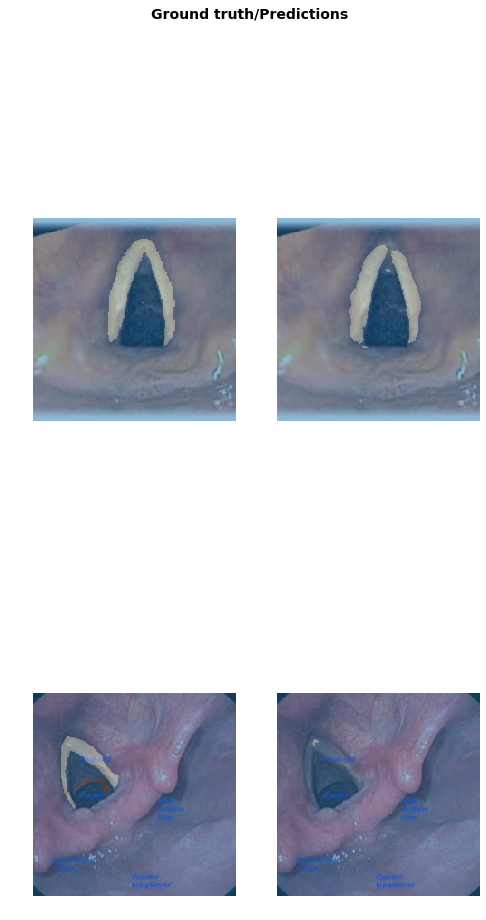

In [110]:
learn.show_results(rows=5, figsize=(8,16))

Prediction time: 0.1236424446105957


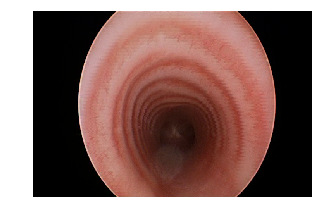

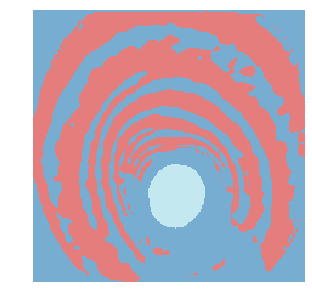

In [113]:
import time

img = open_image(get_image_files(path_img)[60])
start = time.time()
prediction = learn.predict(img)
end = time.time()
print("Prediction time: {}".format(end - start))
img.show(figsize=(5,5),alpha=0.4)
prediction[0].show(figsize=(5,5), alpha=0.6)

# ??learn.predict

In [32]:
learn.load('stage-2-big') # or whatever your saved model is
example = torch.rand(2, 3, 224, 224) # dummy batch size, n_chanels, w, h
learn.model.training = False # disable dropout
learn.model = learn.model.cpu() # move to CPU

In [34]:
#traced_script_module = torch.jit.trace(learn.model, example)
# traced_script_module.save("model.pt")

## Closing notes:

Architecture: U-Net with (ResNet34 for encoder)

Training Dataset Size: 88 imgs

Validation Dataset Size: 16 imgs

Prediction time: ~3ms

Accuracy: 97.45%

In [29]:
from fastai.datasets import *

Object ` fastai.datasets` not found.
